# Das Hadeler Problem

\begin{gather}
    T(z) = (e^z - 1) B_1 + z^2 B_2 - B_0 \\
    B_0 = b_0 I_{n\times n}, \quad B_1 = (b_{jk}^{(1)}), \quad B_2 = (b_{jk}^{(2)}) \\
    b_{jk}^{(1)} = (n + 1 - \max(j, k)) j k, \quad b_{jk}^{(2)} = n \delta_{jk} + 1 / (j + k), \quad j,k = 1,\dots,n
\end{gather}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from outsource import *

## Parameter

In [2]:
n = 200
b_0 = 100

In [3]:
b_1 = lambda j, k: (n + 1 - max(j, k)) * j * k
b_2 = lambda j, k: n * int(j == k) + 1 / (j + k)

B_0 = b_0 * np.eye(n)
B_1 = np.array([[b_1(j+1, k+1) for k in range(n)] for j in range(n)])
B_2 = np.array([[b_2(j+1, k+1) for k in range(n)] for j in range(n)])

T = lambda z: (np.exp(z) - 1) * B_1 + z ** 2 * B_2 - B_0

In [4]:
N = n

## Der Algorithmus

In [5]:
# quadrature nodes on unit circle
omega = lambda m: np.exp(2 * np.pi * 1j / m)

# quadrature on 0-centered ball with radius R
Q_zero = lambda m, f, R: R / m * sum([
    omega(m) ** nu * f(R * omega(m) ** nu)
    for nu in range(m)
])

# quadrature of f on z-centered ball with radius R and m quadrature nodes
Q = lambda m, f, R, z: Q_zero(m, lambda x: f(x + z), R)

# ---------------------------------------------------------------- #

def integral_method(A, N, j, m, R, z, tol, debug = False):

    """
    A ... matrix-function
    N ... number of rows/columns of A(lambda)
    j ... number of expected eigen values in ball B_R(z) ...
    m ... number of quadrature nodes
    R ... ball-radius
    z ... ball-center
    tol ... tolerance for singular value decomposition reduction
    """

    # random matrix
    V_hat = np.random.random((N, j))

    # ------------------------ #
    # step 1: calculate A_0 and A_1

    # integrand of A_0 and A_1 (with index 0 resp. 1)
    def integrand(index, lamda):

        LU, piv = linalg.lu_factor(A(lamda))

        return lamda ** index * np.array([
            linalg.lu_solve((LU, piv), V_hat[:, i])
            for i in range(j)
        ]).T

    f_0 = lambda lamda: integrand(0, lamda)
    f_1 = lambda lamda: integrand(1, lamda)

    # apply quadrature formula to integrand for A_0 and A_1
    A_0 = Q(m, f_0, R, z)
    A_1 = Q(m, f_1, R, z)

    # ------------------------ #
    # step 2: calculate and reduce singular value decomposition to J singular values

    # get full i.e. unreduced singular value decomposition
    V_tilde_full, Sigma_full, W_tilde_full = linalg.svd(A_0, full_matrices = False)
    
    # mask for SVD reduction (kill zero values)
    mask = np.abs(Sigma_full) > tol

    # apply mask i.e. reduce SVD
    Sigma_reduced = Sigma_full[mask]
    V_tilde_reduced = V_tilde_full[:, mask]
    W_tilde_reduced = W_tilde_full[mask, :]

    # ------------------------ #
    # step 3: calculate eigen values (e.g. via QR-method)

    eigen_values = linalg.eigvals(
        V_tilde_reduced.conj().T @ A_1 @ W_tilde_reduced.conj().T @ np.diag(Sigma_reduced ** (-1))
    )

    if debug:
        return {
            "eigen_values": eigen_values,
            "V_hat": V_hat,
            "integrand": integrand, 
            "f_0": f_0, 
            "f_1": f_1,
            "A_0": A_0, 
            "A_1": A_1,
            "V_tilde_full": V_tilde_full, 
            "Sigma_full": Sigma_full, 
            "W_tilde_full": W_tilde_full,
            "V_tilde_reduced": V_tilde_reduced, 
            "Sigma_reduced": Sigma_reduced, 
            "W_tilde_reduced": W_tilde_reduced
        }
    else:
        return eigen_values


## 1. Testlauf

Beim Test 1 haben wir die Referenzwerte explizit in der Hand gehabt.
Jetzt müssen wir diese semi-analytisch bestimmen.
Dazu schließen wir sie mit `integral_method` zunächst in eine hinreichend große Kurve ein.

In [24]:
j = 20
m = 100
R = 11.5
z = -30
tol = 1e-5

quadrature_nodes = [R * (omega(m) ** nu) + z for nu in range(m)]

debug_dict = integral_method(T, N, j, m, R, z, tol, True)
eigen_values_ref = debug_dict["eigen_values"]
sigma_full = debug_dict["Sigma_full"]
eigen_values_fake   = integral_method(T, N, j, m, R, z, 0)

### Bestimmung der "korrekten" Singulärwerte

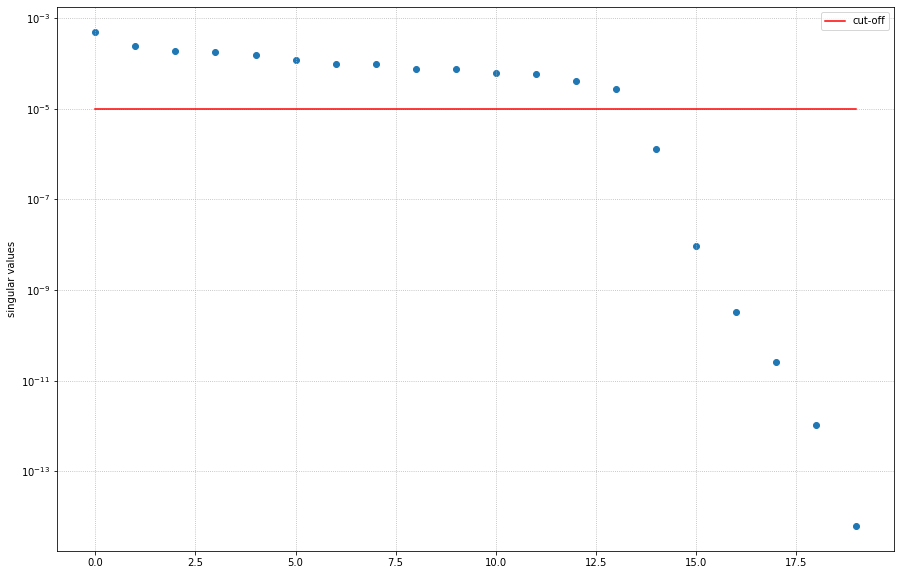

In [7]:
ax = plt.figure(figsize = (15, 10)).gca()
ax.scatter(range(len(sigma_full)), sigma_full)
ax.plot(
    range(len(sigma_full)),
    [tol] * len(sigma_full), color = "r", label = "cut-off"
)
ax.set_yscale("log")

ax.set_ylabel("singular values")

ax.grid(linestyle = ':')

ax.legend()
plt.show()

Wir bekommen also scheinbar tatsächlich $14$ "echte" Eigenwerte (über der Abtrennung).

### Eigenwert überprüfen

Eine Heuristik, um Eigenwerte $\lambda$ zu identifizieren, d.h. ob $A(\lambda)$ singulär ist, besteht darin, die Konditionszahl zu betrachten.
Wenn diese sehr groß wird, dann ist $A(\lambda)$ (fast) singulär.

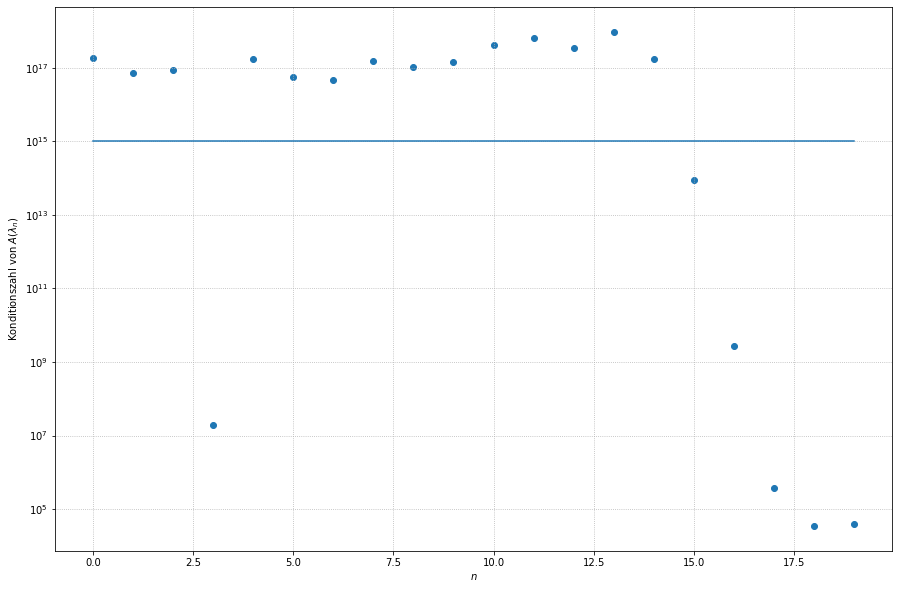

In [9]:
ax = plt.figure(figsize = (15, 10)).gca()

eigen_value_indices = range(len(eigen_values_fake))

ax.scatter(
    eigen_value_indices,
    [np.linalg.cond(T(ref)) for ref in eigen_values_fake]
)

ax.plot(
    eigen_value_indices,
    [1e15] * len(eigen_value_indices)
)

ax.grid(linestyle = ':')
ax.set_yscale('log')

ax.set_xlabel('$n$')
ax.set_ylabel('Konditionszahl von $A(\lambda_n)$')

plt.show()

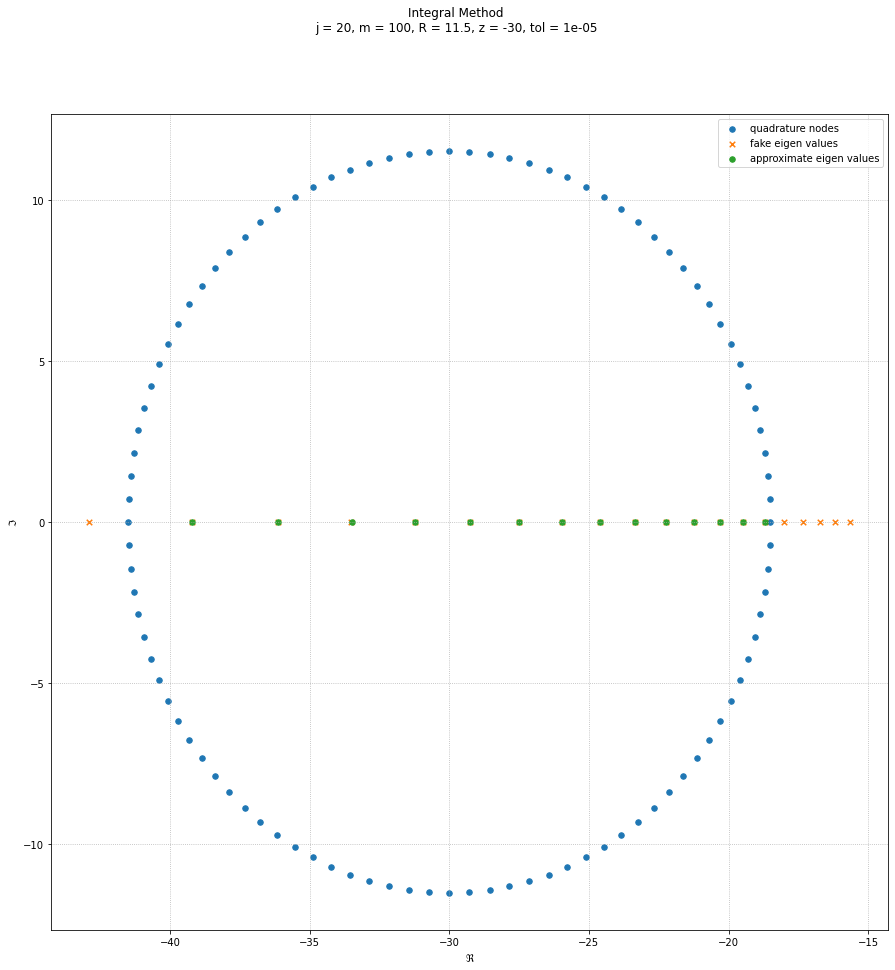

In [9]:
title = 'Integral Method' + '\n' + f'j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('quadrature nodes', 'fake eigen values', 'approximate eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_fake, eigen_values_ref],
    title, legend,
    size_dots = 30
)


## Pitfalls

### Zu ungenaue Quadratur

Wenn wir zu wenige Quadraturknoten wählen, fehlt uns die notwendige Genauigkeit um die
"korrekten" Singulärwerte zielsicher von den zusätzlichen Werten zu trennen.

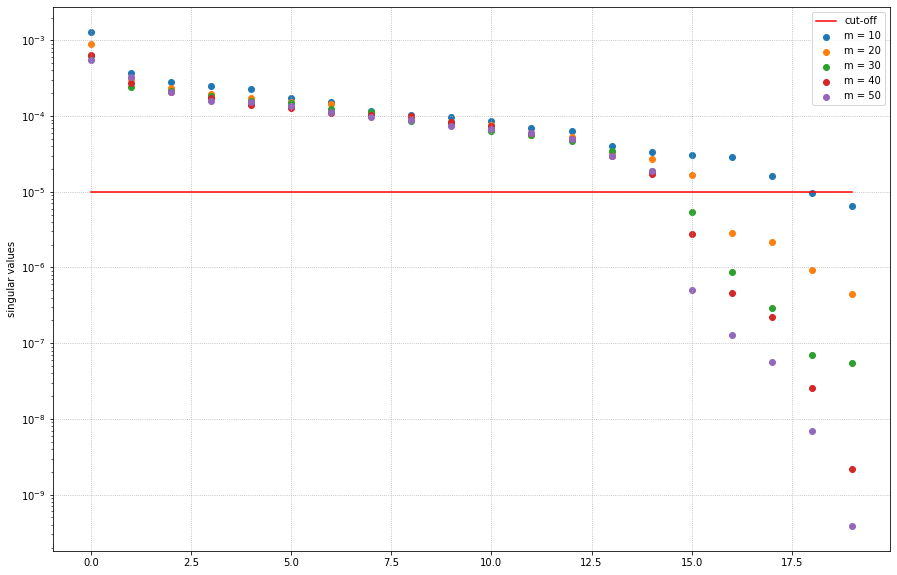

In [10]:
ax = plt.figure(figsize = (15, 10)).gca()

for m in [10,20,30,40,50]:
    sigma_full = integral_method(T, N, j, m, R, z, tol, True)["Sigma_full"]
    ax.scatter(range(len(sigma_full)), sigma_full, label = "m = {}".format(m))
    
ax.plot(
    range(len(sigma_full)),
    [tol] * len(sigma_full), color = "r", label = "cut-off"
)
ax.set_yscale("log")

ax.set_ylabel("singular values")

ax.grid(linestyle = ':')

ax.legend()
plt.show()

### Zu kleine Zufallsmatrix

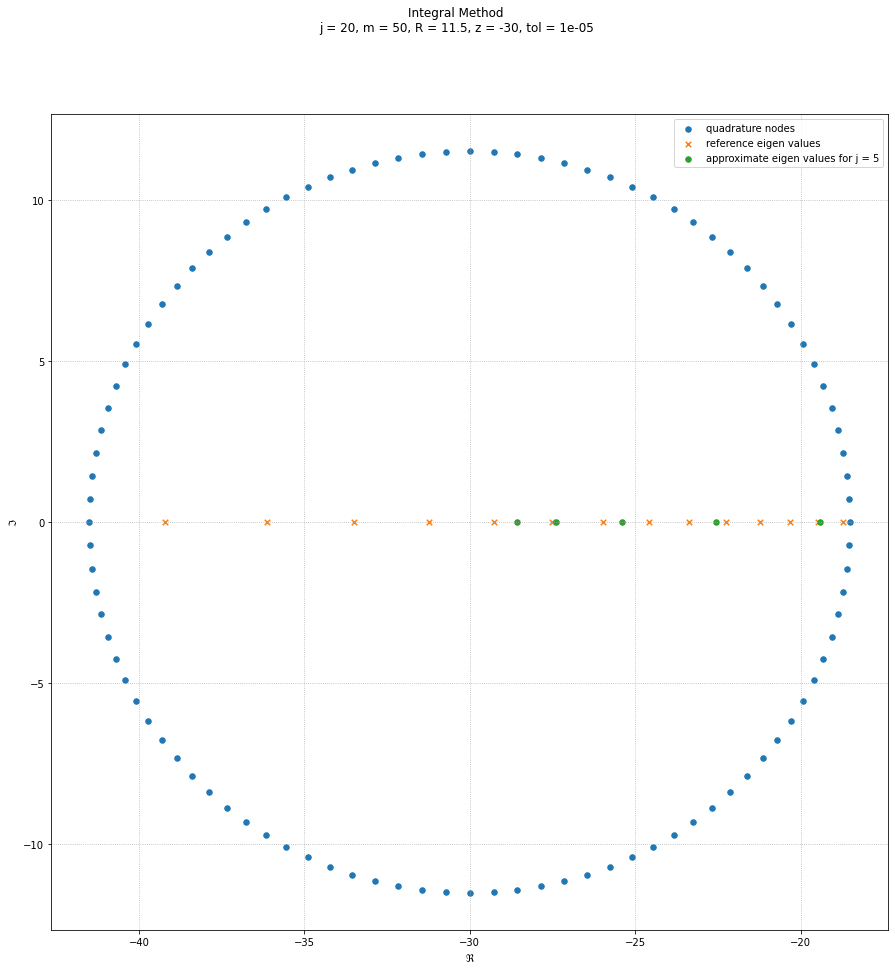

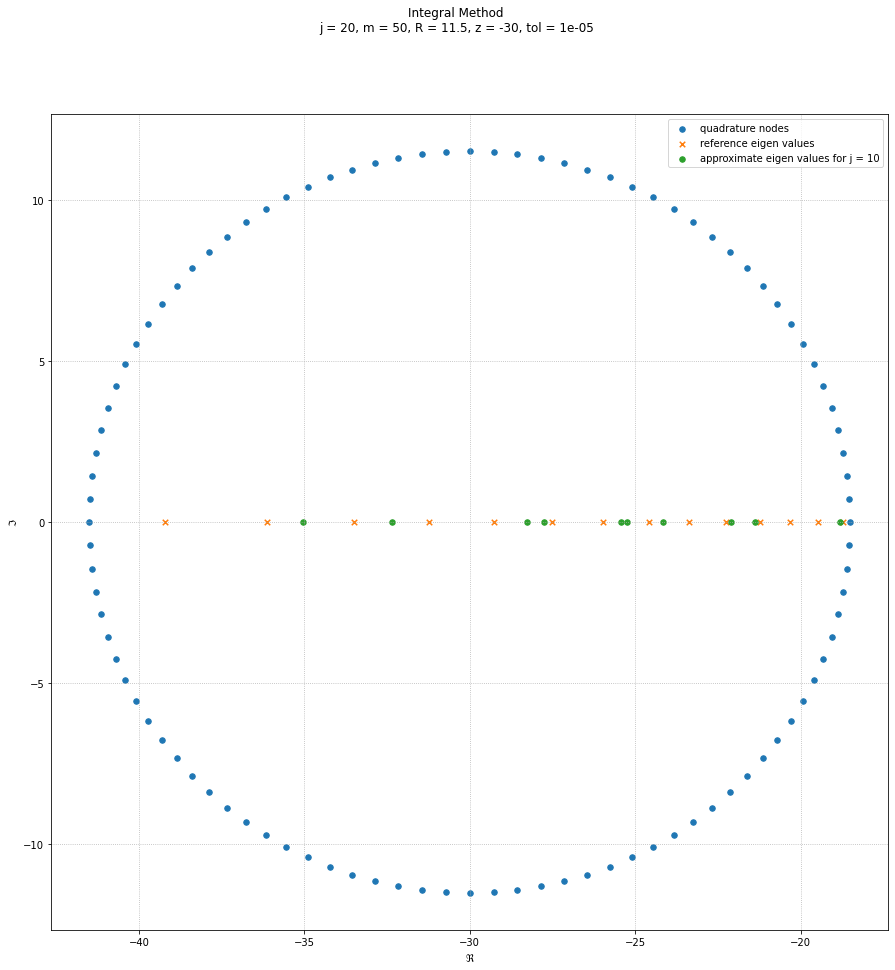

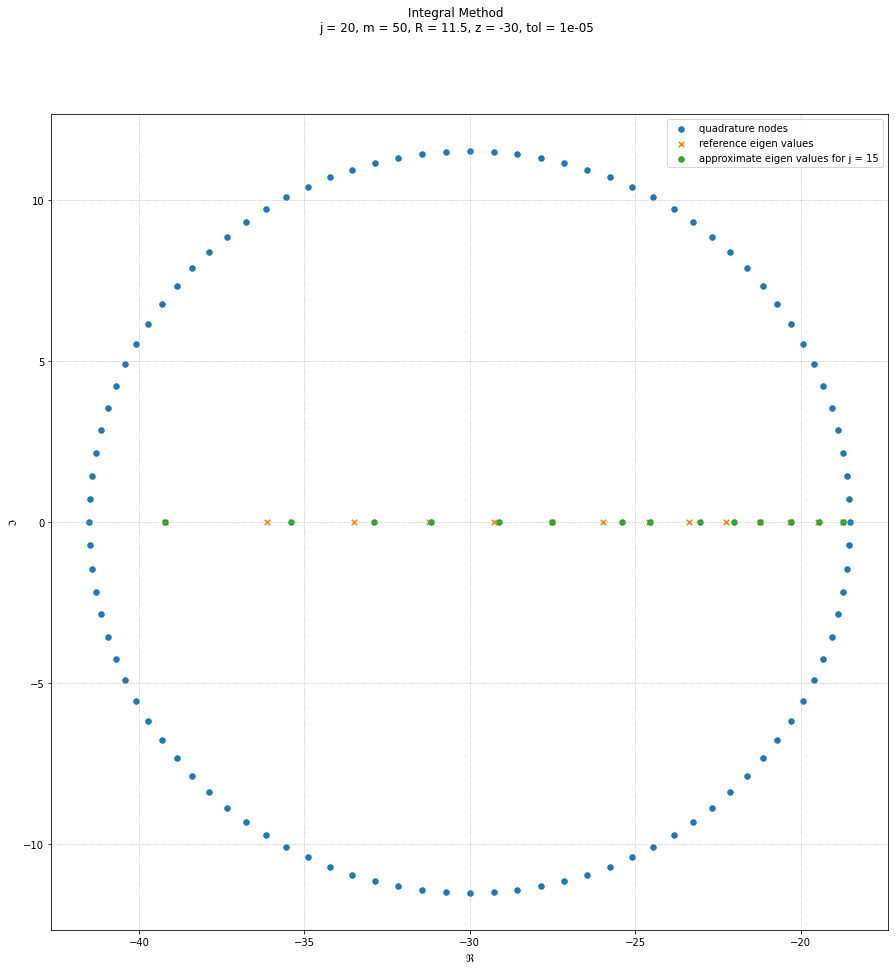

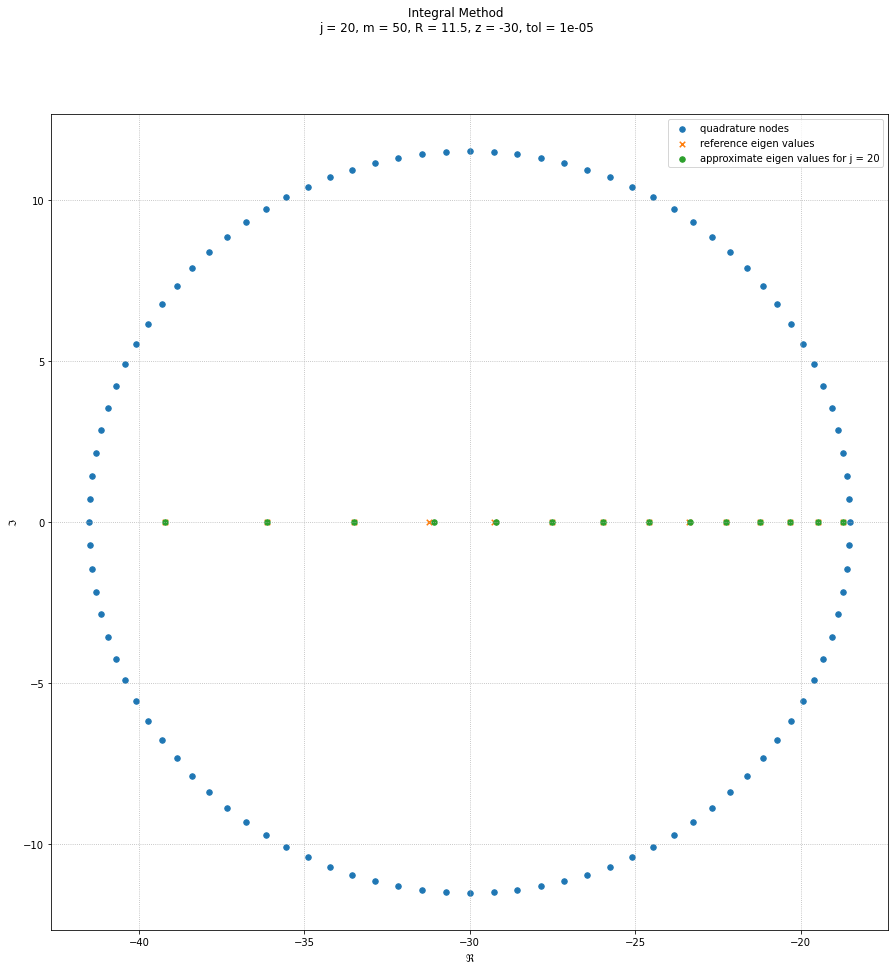

In [14]:
title = 'Integral Method' + '\n' + f'j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'


j_array = [5,10,15,20]
m = 50
for j in j_array:
    legend = ['quadrature nodes', 'reference eigen values', 'approximate eigen values for j = {}'.format(j)]
    eigen_values_approx = integral_method(T, N, j, m, R, z, tol)
    plot_complex(
        [quadrature_nodes, eigen_values_ref, eigen_values_approx],
        title, legend,
        size_dots = 30
    )


## Genauere Referenzwerte für Konvergenzanalyse

Dann wenden wir `integral_method` auf die einzelnen Werte nochmal an, mit kleineren Kurven.

In [91]:
# we expect only 1 eigen_value
j = 2

m = 200

# make radius with smaller radius
# the center point z will be each eigen value
R = 0.5

eigen_values_ref2 = [
    integral_method(T, N, j, m, R, eigen_value, tol)[0]
    for eigen_value in eigen_values_ref]

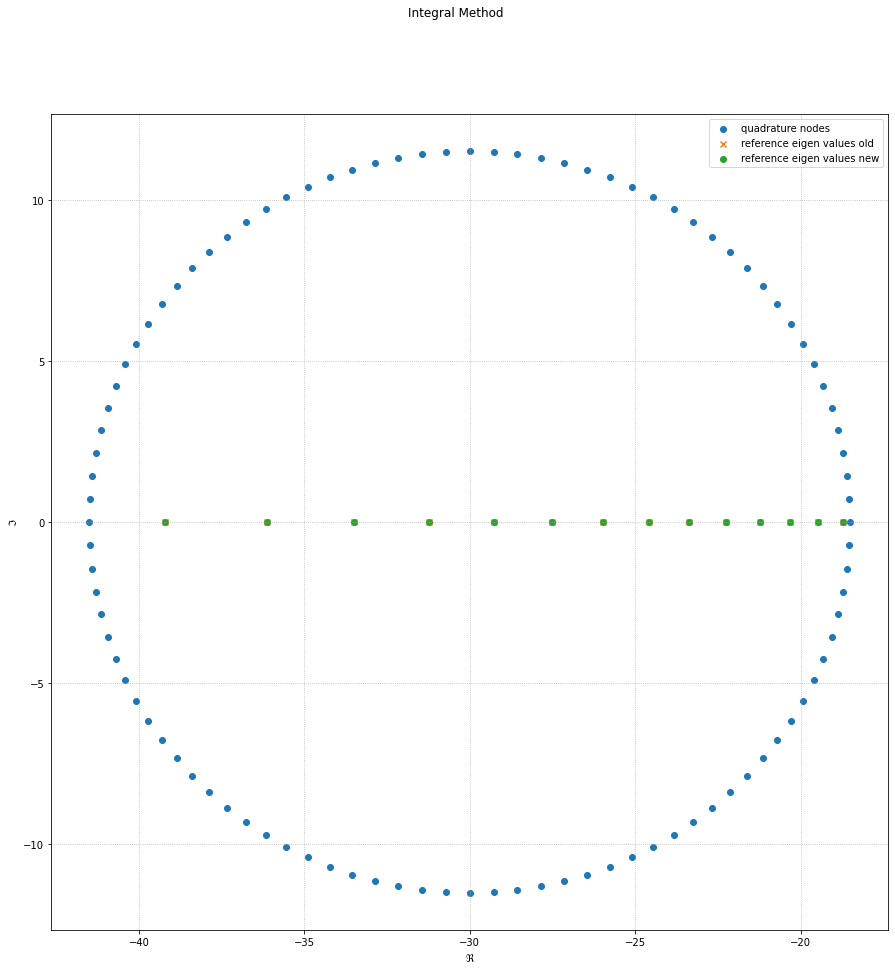

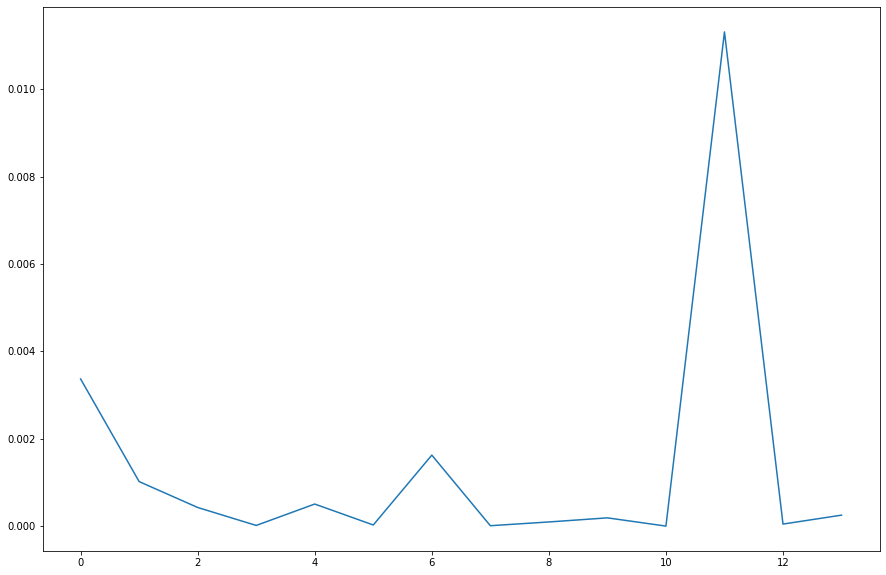

In [92]:
title = 'Integral Method'
legend = ('quadrature nodes', 'reference eigen values old', 'reference eigen values new')

plot_complex(
    [quadrature_nodes, eigen_values_ref, eigen_values_ref2],
    title, legend
)

diff = [np.abs(ev - ev2) for ev,ev2 in zip(eigen_values_ref,eigen_values_ref2)]

ax = plt.figure(figsize = (15, 10)).gca()

ax.plot(range(len(diff)),diff)

plt.show()

## Konvergenzgeschwindigkeit in Abhängigkeit des gewählten Kreises

Gemäß der Analyse des Algorithmus erwarten wir eine umso schnellere Konvergenzgeschwindigkeit,
je weiter die Kurve über die wir integrieren vom nächsten Eigenwert entfernt ist.

In [105]:
j = 20
m_array = [5, 10, 15, 20, 50, 75, 100]

max_R = max([np.abs(z - eigen_value) for eigen_value in eigen_values_ref2])
R_array = [max_R - 0.01, max_R - 0.1, max_R - 0.5]
z = -30
tol = 1e-6

error_arrays = [
    [
        max([
            min([
                np.abs(eigen_value_approx - eigen_value_ref)
                for eigen_value_ref in eigen_values_ref2
            ])
            for eigen_value_approx in integral_method(T, N, j, m, R, z, tol)
        ])
        for m in m_array
    ]
    for R in R_array
]

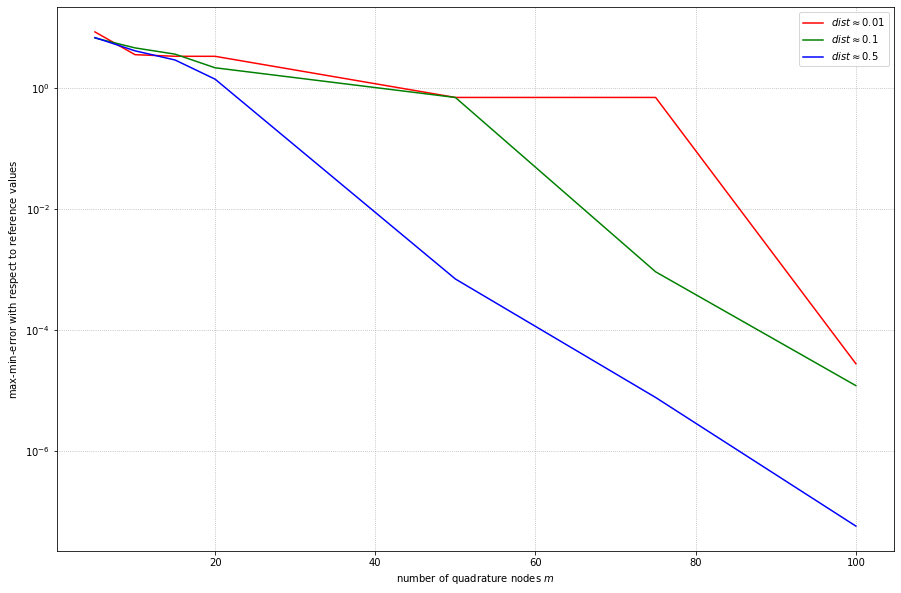

In [106]:
ax = plt.figure(figsize = (15, 10)).gca()

for error_array, dist, color in zip(error_arrays, [0.01,0.1,0.5], ["r","g","b"]):
    ax.semilogy(m_array, error_array, color, 
                label = r'$dist \approx {0}$'.format(dist))
ax.set_xlabel('number of quadrature nodes $m$')
ax.set_ylabel('$\max$-$\min$-error with respect to reference values')

ax.legend()
ax.grid(linestyle = ':')

plt.show()

# Fazit

Die Konturintegralmethode ist eine Methode zur Lösung nichtlinearer Eigenwertprobleme
über den Satz von Keldysh.
Die zentrale Formel die dem Algorithmus zu Grunde liegt ist folgende:

\begin{gather}
\frac{1}{2 \pi i} \int_{\Gamma} f(\lambda) A(\lambda)^{-1} \mathrm{d}\lambda =
\sum_{n=1}^k f(\lambda_n)\sum_{l=1}^{L_n}v_{n, l} w_{n, l}^\ast.
\end{gather}

Damit können wir die Matrizen

\begin{gather}
 A_0 := VW^*\hat{V} = \frac{1}{2\pi i} \int_\Gamma A(\lambda)^{-1}\hat{V}\mathrm{d}\lambda \in \mathbb{C}^{N \times j} \\
 A_1 := VDW^*\hat{V} = \frac{1}{2\pi i} \int_\Gamma \lambda A(\lambda)^{-1}\hat{V}\mathrm{d}\lambda \in \mathbb{C}^{N \times j}
\end{gather}

berechnen, die reduzierte Singulärwertzerlegung

\begin{gather}
A_0 = \tilde{V}\Sigma\tilde{W}^*
\end{gather}

durchführen und somit das nichtlineare Eigenwertproblem auf das lineare Eigenwertproblem der Matrix

\begin{gather}
\tilde{V}^*A_1\tilde{W}\Sigma^{-1} \approx D
\end{gather}

reduzieren, welches beispielsweise mit dem QR-Verfahren lösbar ist.


## Vorteile

* Deutliche Vereinfachung der Lösung von nichtlinearen Eigenwertproblemen
* Berechnet alle Eigenwerte innerhalb einer gegebenen Kurve

## Nachteile

* hoher Berechnungsaufwand
* Schwierigkeiten die "korrekten" Singulärwerte zu bestimmen